
Reading CSV files:
  Reading: differential_cy_easier.csv
  Reading: differential_cy_easy.csv
  Reading: differential_cy_hard.csv
  Reading: differential_cy_harder.csv
  Reading: differential_cy_moderate.csv
  Reading: differential_dh_easier.csv
  Reading: differential_dh_easy.csv
  Reading: differential_dh_hard.csv
  Reading: differential_dh_harder.csv
  Reading: differential_dh_moderate.csv
  Reading: differential_gb_easier.csv
  Reading: differential_gb_easy.csv
  Reading: differential_gb_hard.csv
  Reading: differential_gb_harder.csv
  Reading: differential_gb_moderate.csv
  Reading: differential_jj_easier.csv
  Reading: differential_jj_easy.csv
  Reading: differential_jj_hard.csv
  Reading: differential_jj_harder.csv
  Reading: differential_jj_moderate.csv
  Reading: differential_jw_easier.csv
  Reading: differential_jw_easy.csv
  Reading: differential_jw_hard.csv
  Reading: differential_jw_harder.csv
  Reading: differential_jw_moderate.csv
  Reading: differential_kb_easier.csv
  

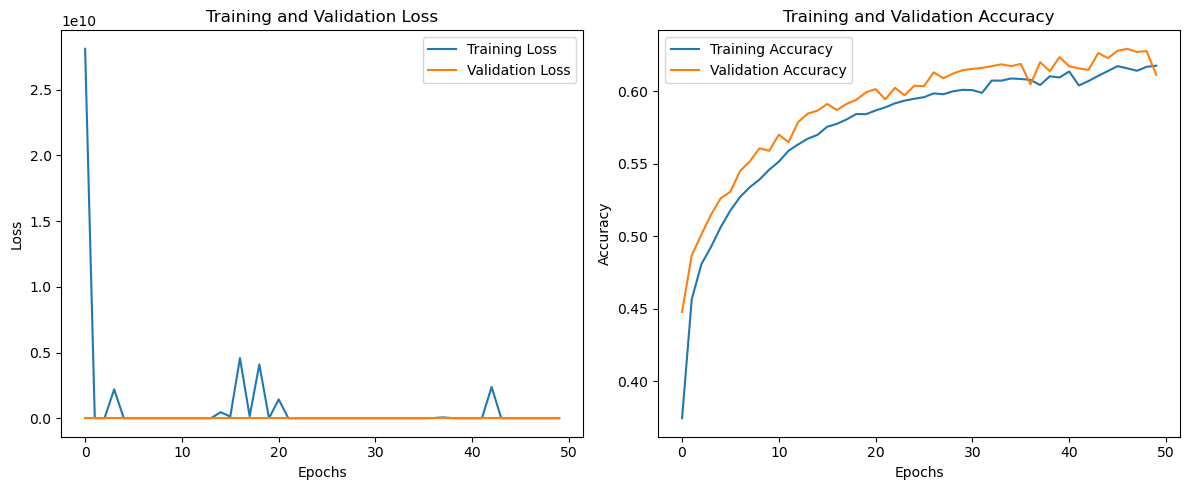

Evaluating model...
19020/19020 [==============================] - 52s 3ms/step
Accuracy for fold 1: 0.6115
Classification Report:
              precision    recall  f1-score   support

      easier       0.40      0.82      0.54    121723
        easy       0.72      0.54      0.62    121722
        hard       0.81      0.55      0.65    121722
      harder       0.74      0.60      0.66    121723
    moderate       0.76      0.54      0.63    121722

    accuracy                           0.61    608612
   macro avg       0.69      0.61      0.62    608612
weighted avg       0.69      0.61      0.62    608612



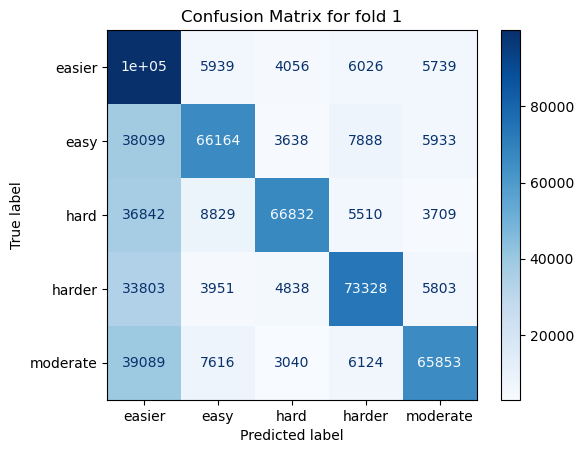


Stratified K-Fold Iteration 2/5
Training model...


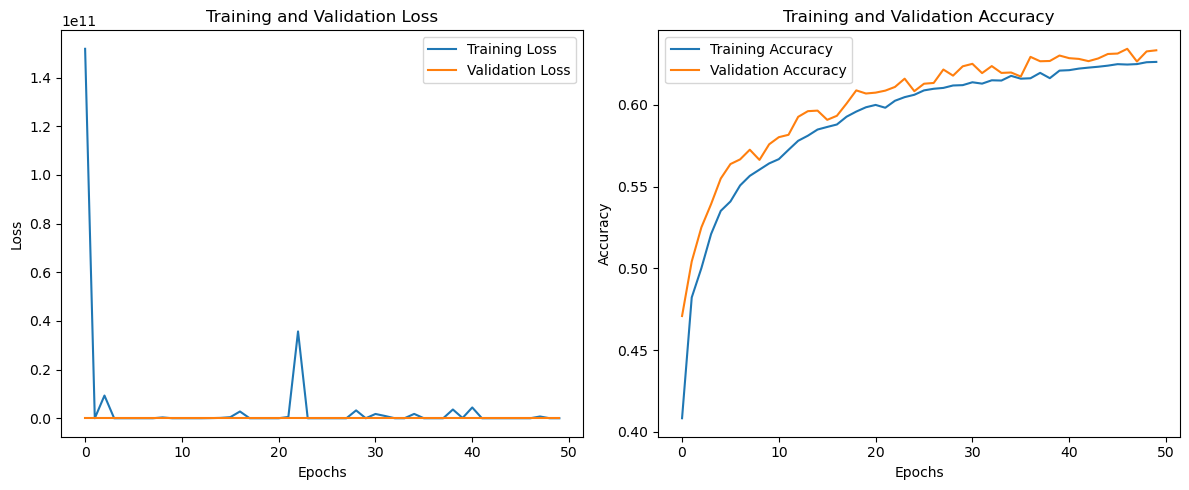

Evaluating model...
19020/19020 [==============================] - 50s 3ms/step
Accuracy for fold 2: 0.6333
Classification Report:
              precision    recall  f1-score   support

      easier       0.41      0.85      0.55    121722
        easy       0.77      0.56      0.65    121723
        hard       0.82      0.60      0.70    121722
      harder       0.82      0.59      0.68    121722
    moderate       0.77      0.57      0.65    121723

    accuracy                           0.63    608612
   macro avg       0.72      0.63      0.65    608612
weighted avg       0.72      0.63      0.65    608612



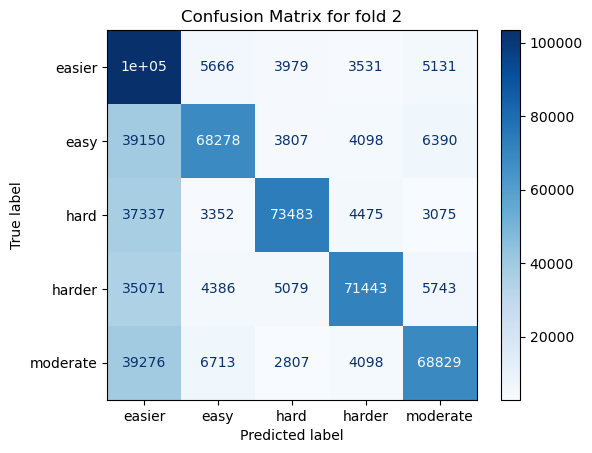


Stratified K-Fold Iteration 3/5
Training model...


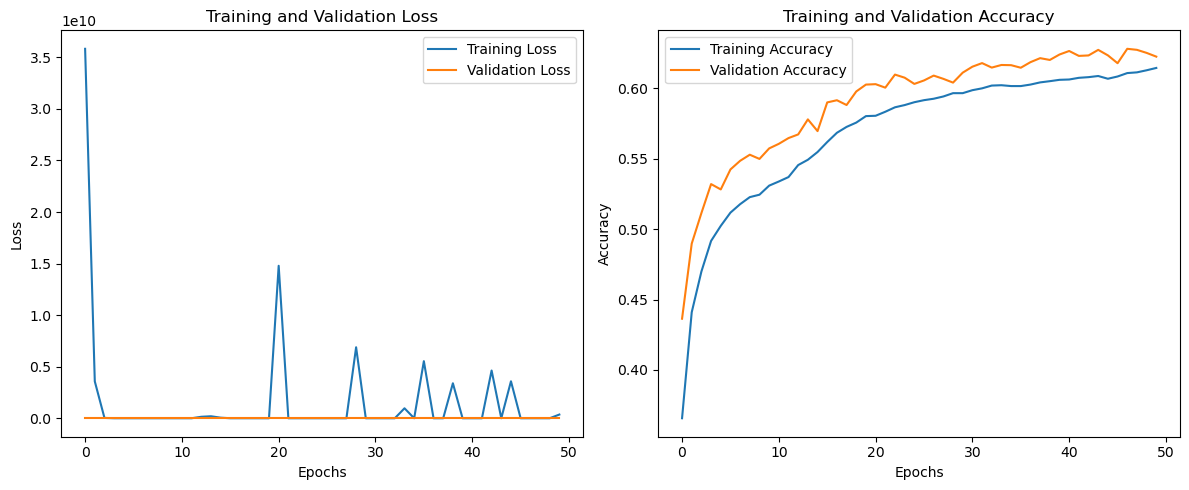

Evaluating model...
19020/19020 [==============================] - 50s 3ms/step
Accuracy for fold 3: 0.6224
Classification Report:
              precision    recall  f1-score   support

      easier       0.80      0.53      0.64    121722
        easy       0.40      0.87      0.55    121722
        hard       0.84      0.58      0.69    121723
      harder       0.75      0.62      0.68    121722
    moderate       0.80      0.52      0.63    121722

    accuracy                           0.62    608611
   macro avg       0.72      0.62      0.64    608611
weighted avg       0.72      0.62      0.64    608611



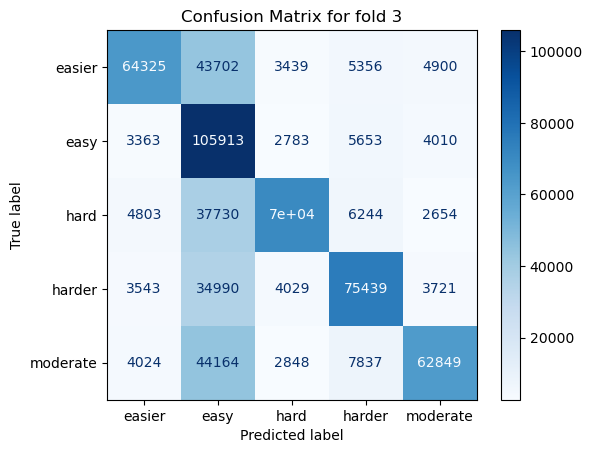


kfold evaluation results:
Mean accuracy: 0.6224 (+/- 0.0089)

Training final model on all data...
Epoch 1/50
7133/7133 [==============================] - 48s 7ms/step - loss: 41188409344.0000 - accuracy: 0.3734
Epoch 2/50
7133/7133 [==============================] - 48s 7ms/step - loss: 626682624.0000 - accuracy: 0.4220
Epoch 3/50
7133/7133 [==============================] - 47s 7ms/step - loss: 1.1976 - accuracy: 0.4590
Epoch 4/50
7133/7133 [==============================] - 46s 6ms/step - loss: 201738064.0000 - accuracy: 0.4767
Epoch 5/50
7133/7133 [==============================] - 47s 7ms/step - loss: 1.1311 - accuracy: 0.4934
Epoch 6/50
7133/7133 [==============================] - 46s 6ms/step - loss: 1.1013 - accuracy: 0.5093
Epoch 7/50
7133/7133 [==============================] - 48s 7ms/step - loss: 1.0814 - accuracy: 0.5178
Epoch 8/50
7133/7133 [==============================] - 47s 7ms/step - loss: 1.0638 - accuracy: 0.5256
Epoch 9/50
7133/7133 [=============================

Traceback (most recent call last):
  File "C:\Users\USER\AppData\Local\Temp\ipykernel_8372\4231740532.py", line 420, in main
    final_model.save(model_filename)
  File "c:\Users\USER\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\USER\anaconda3\lib\site-packages\tensorflow\python\lib\io\file_io.py", line 511, in recursive_create_dir_v2
    _pywrap_file_io.RecursivelyCreateDir(compat.path_to_bytes(path))
tensorflow.python.framework.errors_impl.PermissionDeniedError: Failed to create a directory: C:\Users/HCIS; Permission denied


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import time
import warnings

# Change csv files to dataframes
def read_csv_files(directory):
    data_frames = {}
    print("\nReading CSV files:")
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            print(f"  Reading: {filename}")
            df = pd.read_csv(os.path.join(directory, filename))
            parts = filename.split('_')
            file_type = parts[0]
            participant = parts[-2] if len(parts) > 2 else 'unknown'
            difficulty = parts[-1].split('.')[0] if len(parts) > 1 else 'unknown'
            if not file_type == 'E4 ACC data':
                key = (participant, difficulty, file_type)
                data_frames[key] = df
            else:
                print(f"    Skipped: {filename} (ACC data)")
    print(f"Total files read: {len(data_frames)}")
    return data_frames

# Select useful data only (after game start, interpolate)
def preprocess_data(df, baseline_duration):
    if 'started' in df['game started'].values:
        start_idx = df[df['game started'] == 'started'].index[0]
        start_unix_time = df.loc[start_idx, 'UNIX Time']
        target_unix_time = start_unix_time - baseline_duration
        idx = (df['UNIX Time'] - target_unix_time).abs().idxmin()
        df = df.iloc[idx:]
    else:
        print("Warning: 'game start' marker not found. Using all data.")
        
    warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
    
    return df

def z_score_normalize(df, baseline_duration):
    numeric_columns = df.select_dtypes(include=[np.number]).columns.drop('UNIX Time')
    baseline = df.iloc[:baseline_duration]
    mean = baseline[numeric_columns].mean()
    std = baseline[numeric_columns].std()
    std = std.replace(0, 1)  # Replace zero std with 1 to avoid division by zero
    normalized_df = df.copy()
    normalized_df[numeric_columns] = (df[numeric_columns] - mean) / std
    return normalized_df

def process_data(df, baseline_duration):
    df = preprocess_data(df, baseline_duration)
    
    if 'UNIX Time' not in df.columns or df['UNIX Time'].isnull().all():
        print("Error: 'UNIX Time' column not found or all values are null")
        return pd.DataFrame()
    
    game_start_time = df['UNIX Time'].min()
    
    unix_time = df['UNIX Time']
    df_numeric = df.select_dtypes(include=[np.number]).drop(columns=['UNIX Time'])
    df_numeric['UNIX Time'] = unix_time
    
    normalized_df = z_score_normalize(df_numeric, baseline_duration)
    
    df_after_start = normalized_df[normalized_df['UNIX Time'] >= game_start_time]
    
    if df_after_start.empty:
        print(f"Warning: No data available after assumed game start")
        return pd.DataFrame()
    
    df_numeric = df_after_start.drop(columns=['UNIX Time'])
    
    return df_numeric

def make_sequences(df, window_size):
    sequences = []
    for i in range(0, len(df) - window_size + 1):
        sequences.append(df.iloc[i:i+window_size].values)
    return np.array(sequences)

def create_dataset(data_frames, window_size, expected_features, baseline_duration):
    X_data = []
    y_data = []
    participant_data = []
    all_columns = set()
    
    for (participant, difficulty, file_type), df in data_frames.items():
        processed_df = process_data(df, baseline_duration)
        all_columns.update(processed_df.columns)
    
    all_columns = sorted(list(all_columns))[:expected_features]  # Limit to expected number of features
    
    for (participant, difficulty, file_type), df in data_frames.items():
        processed_df = process_data(df, baseline_duration)
        
        for col in all_columns:
            if col not in processed_df.columns:
                processed_df[col] = 0
        
        processed_df = processed_df[all_columns]
        
        # Pad or truncate to match expected features
        if processed_df.shape[1] < expected_features:
            padding = pd.DataFrame(0, index=processed_df.index, 
                                   columns=[f'pad_{i}' for i in range(expected_features - processed_df.shape[1])])
            processed_df = pd.concat([processed_df, padding], axis=1)
        elif processed_df.shape[1] > expected_features:
            processed_df = processed_df.iloc[:, :expected_features]
            
        sequences = make_sequences(processed_df, window_size)
        if len(sequences) > 0:
            X_data.append(sequences)
            y_data.extend([difficulty] * len(sequences))
            participant_data.extend([participant] * len(sequences))
    
    X = np.concatenate(X_data)
    y = np.array(y_data)
    participants = np.array(participant_data)
    
    return X, y, participants

def create_advanced_lstm_model(input_shape, n_classes, lstm_units, dense_units, dropout_rate):
    inputs = Input(shape=input_shape)
    
    low_level = TimeDistributed(Dense(32, activation='relu'))(inputs)
    low_level = TimeDistributed(Dense(16, activation='relu'))(low_level)
    
    high_level = LSTM(lstm_units[0], return_sequences=True)(inputs)
    high_level = LSTM(lstm_units[1])(high_level)
    
    combined = Concatenate()([tf.keras.layers.Flatten()(low_level), high_level])
    
    x = Dense(dense_units, activation='relu')(combined)
    x = Dropout(dropout_rate)(x)
    
    outputs = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def loso_evaluation(X, y, participants, n_classes, hyperparameters):
    logo = LeaveOneGroupOut()
    
    loso_scores = []
    for i, (train_index, test_index) in enumerate(logo.split(X, y, participants)):
        print(f"\nLOSO Iteration {i+1}/{len(np.unique(participants))}")
        print(f"Test participant: {participants[test_index[0]]}")
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Validation split from the train set
        val_split_idx = int(0.8 * len(X_train))  # 80% train, 20% validation
        X_train, X_val = X_train[:val_split_idx], X_train[val_split_idx:]
        y_train, y_val = y_train[:val_split_idx], y_train[val_split_idx:]
        
        model = create_advanced_lstm_model(
            input_shape=(X_train.shape[1], X_train.shape[2]),
            n_classes=n_classes,
            lstm_units=hyperparameters['lstm_units'],
            dense_units=hyperparameters['dense_units'],
            dropout_rate=hyperparameters['dropout_rate']
        )
        
        le = LabelEncoder()
        y_train_cat = to_categorical(le.fit_transform(y_train))
        y_val_cat = to_categorical(le.transform(y_val))
        y_test_cat = to_categorical(le.transform(y_test))
        
        # EarlyStopping 콜백 추가
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        print("Training model...")
        history = model.fit(X_train, 
                            y_train_cat,
                            epochs=hyperparameters['epochs'], 
                            batch_size=hyperparameters['batch_size'],
                            validation_data=(X_val, y_val_cat),
                            callbacks=[early_stopping], 
                            verbose=0)
        
        # 학습 그래프 그리기
        plt.figure(figsize=(12, 5))

        # Loss 그래프
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        # Accuracy 그래프
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()
        
        print("Evaluating model...")
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test_cat, axis=1)
        
        accuracy = accuracy_score(y_test_classes, y_pred_classes)
        loso_scores.append(accuracy)
        print(f"Accuracy for participant {participants[test_index[0]]}: {accuracy:.4f}")
        
        print("Classification Report:")
        print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))
        
        cm = confusion_matrix(y_test_classes, y_pred_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for participant {participants[test_index[0]]}')
        plt.show()
    
    return np.mean(loso_scores), np.std(loso_scores)

def stratified_kfold_evaluation(X, y, n_classes, hyperparameters):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    fold_accuracies = []
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    for i, (train_index, test_index) in enumerate(skf.split(X, y_encoded)):
        print(f"\nStratified K-Fold Iteration {i+1}/5")
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]
        
        model = create_advanced_lstm_model(
            input_shape=(X_train.shape[1], X_train.shape[2]),
            n_classes=n_classes,
            lstm_units=hyperparameters['lstm_units'],
            dense_units=hyperparameters['dense_units'],
            dropout_rate=hyperparameters['dropout_rate']
        )
        
        y_train_cat = to_categorical(y_train, num_classes=n_classes)
        y_test_cat = to_categorical(y_test, num_classes=n_classes)
        
        # EarlyStopping 콜백 추가
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        print("Training model...")
        history = model.fit(
            X_train, y_train_cat,
            epochs=hyperparameters['epochs'],
            batch_size=hyperparameters['batch_size'],
            validation_data=(X_test, y_test_cat),
            verbose=0
        )
        
        # 학습 그래프 그리기
        plt.figure(figsize=(12, 5))

        # Loss 그래프
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        # Accuracy 그래프
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()
        
        print("Evaluating model...")
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test_cat, axis=1)
        
        accuracy = accuracy_score(y_test_classes, y_pred_classes)
        fold_accuracies.append(accuracy)
        print(f"Accuracy for fold {i+1}: {accuracy:.4f}")
        
        print("Classification Report:")
        print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))
        
        cm = confusion_matrix(y_test_classes, y_pred_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for fold {i+1}')
        plt.show()
    
    return np.mean(fold_accuracies), np.std(fold_accuracies)

def main():
    directory = r'C:\Users\USER\Downloads\pilotdata'
    data_frames = read_csv_files(directory)
    
    window_size = 10  # 10-second window
    n_classes = 5  # Only 5-class classification
    expected_features = 11  # Set this to the number of features you expect
    baseline_duration = 30  # Set this to your baseline duration in seconds
    
    print(f"\n{'='*50}")
    print(f"Running 5-class classification with loso evaluation")
    print(f"{'='*50}")
    
    X, y, participants = create_dataset(data_frames, window_size, expected_features, baseline_duration)
    
    if X is None or y is None or participants is None:
        print("Failed to create dataset.")
        return
    
    print(f"Dataset shape: {X.shape}")
    print(f"Number of sequences: {X.shape[0]}")
    print(f"Sequence length: {X.shape[1]}")
    print(f"Number of features: {X.shape[2]}")
    print(f"Class distribution: {np.unique(y, return_counts=True)}")
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    print("\nApplying SMOTE...")
    smote = SMOTE(random_state=42)
    X_flat = X.reshape(X.shape[0], -1)
    
    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_flat, y_encoded)
    
    # Reshape X back to 3D
    X = X_resampled.reshape(X_resampled.shape[0], X.shape[1], X.shape[2])
    
    print("SMOTE completed.")
    print(f"Original shape: {X_flat.shape}, Resampled shape: {X_resampled.shape}")
    
    # Adjust participants array to match resampled data
    print("Adjusting participants array...")
    participants_resampled = []
    for label in np.unique(y_encoded):
        original_indices = np.where(y_encoded == label)[0]
        resampled_count = np.sum(y_resampled == label)
        participants_for_label = participants[original_indices]
        if len(participants_for_label) > 0:
            participants_resampled.extend(np.repeat(participants_for_label, resampled_count // len(participants_for_label)))
            remainder = resampled_count % len(participants_for_label)
            if remainder > 0:
                participants_resampled.extend(np.random.choice(participants_for_label, size=remainder, replace=True))
    
    participants = np.array(participants_resampled)
    y = le.inverse_transform(y_resampled)
    
    print(f"After SMOTE - Class distribution: {np.unique(y, return_counts=True)}")
    print(f"After SMOTE - Dataset shape: {X.shape, y.shape}")
    print(f"After SMOTE - Participants shape: {participants.shape}")
    
    assert X.shape[0] == y.shape[0] == participants.shape[0], "Mismatch in array lengths after SMOTE"
    
    # Use the best hyperparameters you provided
    best_hyperparameters = {
        'lstm_units': (32, 16),
        'dense_units': 64,
        'dropout_rate': 0.3,
        'epochs': 50,
        'batch_size': 256
    }
    
    try:
        print("\nStarting kfold evaluation with best hyperparameters...")
        loso_mean, loso_std = stratified_kfold_evaluation(X, y, n_classes, best_hyperparameters)
        print(f"\nkfold evaluation results:")
        print(f"Mean accuracy: {loso_mean:.4f} (+/- {loso_std:.4f})")
        
        # Create and train the final model on all data
        final_model = create_advanced_lstm_model(
            input_shape=(X.shape[1], X.shape[2]),
            n_classes=n_classes,
            lstm_units=best_hyperparameters['lstm_units'],
            dense_units=best_hyperparameters['dense_units'],
            dropout_rate=best_hyperparameters['dropout_rate']
        )
        
        y_cat = to_categorical(le.transform(y))
        
        print("\nTraining final model on all data...")
        final_model.fit(X, y_cat, epochs=best_hyperparameters['epochs'], 
                        batch_size=best_hyperparameters['batch_size'], verbose=1)
        
        # Save the final model
        model_filename = r"C:\Users\HCIS\Downloads\pilotdata\best_lstm_model_lowhigh_3class0723.h5"
        final_model.save(model_filename)
        print(f"\nFinal model saved as {model_filename}")
        
        # Save the label encoder
        import joblib
        le_filename = r"C:\Users\HCIS\Downloads\pilotdata\label_encoder_lowhigh0723.joblib"
        joblib.dump(le, le_filename)
        print(f"Label encoder saved as {le_filename}")
        
    except Exception as e:
        import traceback
        print(f"An error occurred during the kfold evaluation or model saving:")
        print(str(e))
        print("Traceback:")
        traceback.print_exc()

if __name__ == "__main__":
    main()